In [1]:
import os
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import pydot

from time import time
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [3]:
def getProjectDir():
    projectDir = ""
    f = os.getcwd().split('/')
    for d in f:
        if d == 'image-captioning':
            projectDir += d
            break;
        projectDir += d + "/"
    return projectDir

In [4]:
projectDir = getProjectDir()
projectDir

'/home/manojmenpadi/Documents/projects/image-captioning'

In [5]:
# Retrieving word indexes
word2idx = None
with open(projectDir + "/Data/word_indexes/" + "word_to_idx.txt", 'r') as f:
    word2idx = f.read()

json_string = word2idx.replace("'","\"")
word2idx = json.loads(json_string)

idx2word = {}
for key in word2idx.keys():
    idx2word[word2idx[key]] = key

In [6]:
# Retrieving train_captions
train_captions = None
with open(projectDir + "/Data/cleaned_data/" + "train_captions.txt", "r") as f:
    train_captions = f.read()
    
json_string = train_captions.replace("'","\"")
train_captions = json.loads(json_string)

In [7]:
# Retrieving encoded data
with open(projectDir + "/Data/encoded_data/" + "encoded_train_features.pkl", 'rb') as f:
    encoding_train = pickle.load(f)

In [8]:
# During preprocessing we saw that max length of captions was 38
max_len = 80
vocab_size = len(word2idx) + 1

## Data preparation using Generator function


In [9]:
def data_generator(train_captions, encoding_train, word2idx, max_len, batch_size):
    X1, X2, y = [],[],[]
    n = 0
    while True:
        for key, cap_list in train_captions.items():
            n += 1
            img = encoding_train[key]
            for cap in cap_list:
                seq = [word2idx[word] for word in cap.split() if word in word2idx]
                for i in range(1, len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    # 0 is used as the padding word
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
                    
                    X1.append(img)
                    X2.append(xi)
                    y.append(yi)
                    
                if n == batch_size:
                    yield [np.array(X1), np.array(X2)], np.array(y)
                    X1, X2, y = [],[],[]
                    n = 0

## Creating word embeddings

In [10]:
f = open(projectDir + "/Data/glove.6B.50d.txt")

In [11]:
embedding_idx = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_idx[word] = word_embedding
   
f.close()

In [12]:
def get_embedding_matrix():
    embed_dim = 50
    matrix = np.zeros((vocab_size, embed_dim))
    
    for word, idx in word2idx.items():
        embedding_vector = embedding_idx.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    
    return matrix

In [13]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(18082, 50)

# Model Architecture 

In [14]:
# Input layers to process image
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [15]:
# Input layers to process Captions
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [16]:
# Layers to Decode inputs
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

In [17]:
# Combining all layers
model = Model(inputs=[input_img_features, input_captions], outputs = outputs)

In [18]:
# Inintialise Embedding layer(embedding_1) with the embedding_matrix
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [19]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 50)       904100      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
_______________________________________________________________________________________

In [20]:
# Compiling model
model.compile(loss='categorical_crossentropy', optimizer="adam")

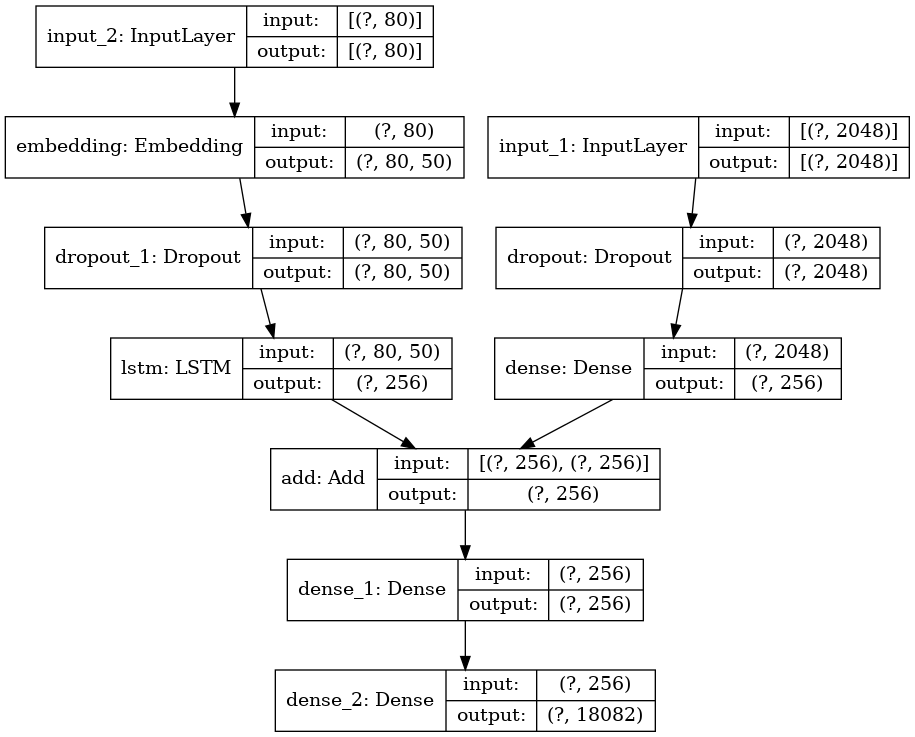

In [21]:
keras.utils.plot_model(model, projectDir + "/model/image_caption_model.png", show_shapes=True)

# Training our Model

In [22]:
epochs = 20
batch_size = 3
steps = len(train_captions)//batch_size

In [23]:
# def train_model():
#     for i in range(epochs):
#         generator = data_generator(train_captions, encoding_train, word2idx, max_len, batch_size)
#         model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#         model.save(projectDir + "/model/model_weights/model_" + str(i) + '.h5')

In [24]:
def train_model():
    model.fit(data_generator(train_captions, encoding_train, word2idx, max_len, batch_size), epochs=epochs, steps_per_epoch=steps, verbose=1)

In [ ]:
# Let's train our model
train_model()

Epoch 1/20
8475/8475 [==============================] - 6091s 719ms/step - loss: 4.1488
Epoch 2/20
8475/8475 [==============================] - 5253s 620ms/step - loss: 3.5594
Epoch 3/20
4225/8475 [=============>................] - ETA: 43:59 - loss: 3.4169

In [27]:
# Let's save our model
model.save(projectDir + "/model/model_20_flickr30k.h5")